<a href="https://colab.research.google.com/github/santolina/Convolutional-Neural-Networks-in-TensorFlow/blob/master/Couse_4_S%2BP_Week_2_Lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0


     |████████████████████████████████| 86.3MB 38kB/s 
     |████████████████████████████████| 3.8MB 40.3MB/s 
     |████████████████████████████████| 450kB 58.4MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)



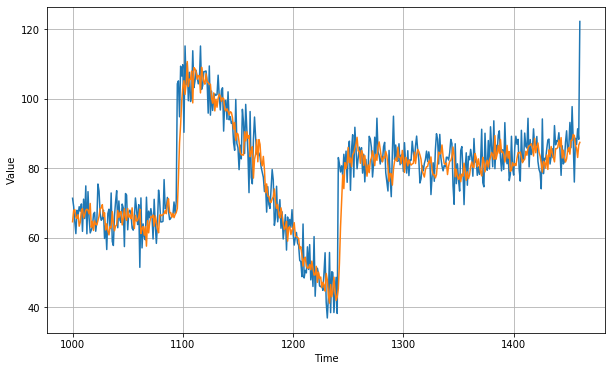

In [5]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [6]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9881177

In [30]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 1859.9197
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 1792.4498
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 1693.0066
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 1605.4464
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 1505.7218
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 1384.6564
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 1265.2633
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 1115.2622
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 949.5381
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 760.1346
Epoch 11/100
31/31 [==============================] - 0s 6ms/step - loss: 549.4250
Epoch 12/100
31/31 [==============================] - 0s 6ms/step - loss: 361.5795
Epoc

[1e-08, 0.001, 0, 300]

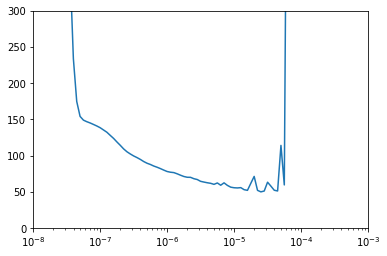

In [31]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [32]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=10e-5, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 17ms/step - loss: 504.8422
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 103.6977
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 81.6877
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 75.5946
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 62.2380
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 59.3502
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 57.4910
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 52.9835
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 52.3067
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 51.3691
Epoch 11/500
31/31 [==============================] - 0s 6ms/step - loss: 53.3082
Epoch 12/500
31/31 [==============================] - 0s 5ms/step - loss: 51.1791
Epoch 13/500
31/31 [==

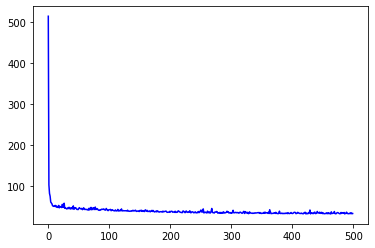

In [33]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[53.37618420001158, 51.04865856367288, 53.58030378990566, 49.85282815756257, 51.61761698771998, 49.083918117247904, 48.88217138703337, 53.64782847374985, 47.84416374914425, 51.300439169972215, 50.09127744694346, 50.09496843790271, 48.50213013481848, 56.206865967426104, 49.71202920343458, 48.85352109535453, 59.03081550991412, 46.56633793152485, 48.17891218834317, 46.65872639134987, 45.18451975006418, 45.450198867640545, 47.86892630193651, 45.85438778277525, 49.226163256537056, 46.73625363222102, 44.73817531939634, 47.60594024658203, 48.29821054517608, 44.973531892127596, 47.43856621968378, 52.57571857884987, 44.14454205699803, 46.896011871652505, 47.85112282664505, 48.158254595884344, 45.308726859338506, 43.84325259493799, 43.88341069958874, 43.61762435755779, 46.60710362699843, 48.26227113389477, 46.234501443449986, 45.33648473208712, 45.72737990703779, 46.46163396540376, 43.34212173776528, 44.6401605350455, 47.93640260991362, 45.22097429885078, 43.66509695151417, 44.19221615348894, 44

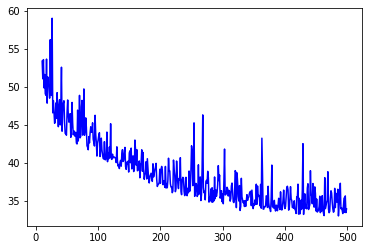

In [36]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

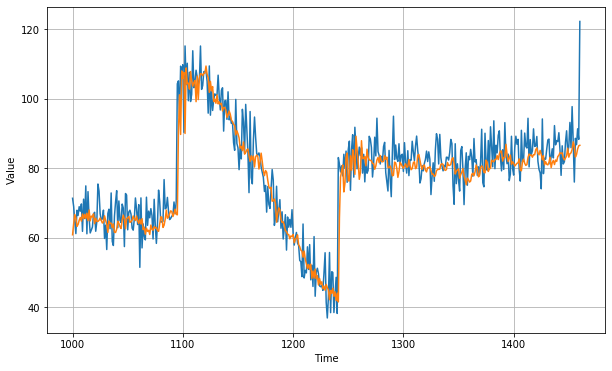

In [37]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9214168

In [39]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 3116.1750
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 2531.6378
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 2349.2995
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 2282.6291
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 2241.3964
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 2203.0987
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 2143.5639
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 2071.3693
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 1951.2034
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 1782.7311
Epoch 11/100
31/31 [==============================] - 0s 6ms/step - loss: 1569.1593
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 1319.7095


[1e-08, 0.001, 0, 300]

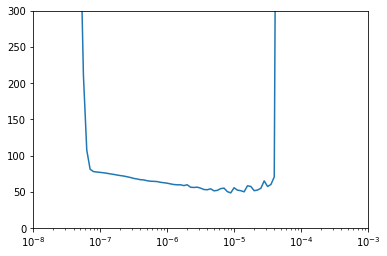

In [40]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [41]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD(lr=10e-5, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 20ms/step - loss: 517.7845
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 97.0996
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 80.2146
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 66.8067
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 63.0940
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 65.8403
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 74.3486
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 63.8877
Epoch 9/500
31/31 [==============================] - 0s 6ms/step - loss: 63.1468
Epoch 10/500
31/31 [==============================] - 0s 6ms/step - loss: 58.9293
Epoch 11/500
31/31 [==============================] - 0s 5ms/step - loss: 55.9226
Epoch 12/500
31/31 [==============================] - 0s 5ms/step - loss: 55.6060
Epoch 13/500
31/31 [===

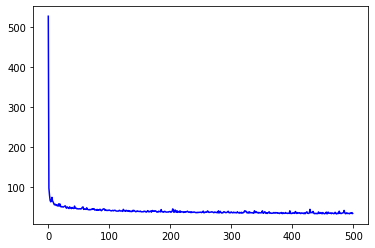

In [42]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[55.62637468318349, 56.97166115672318, 56.56256040592783, 53.862866706454874, 55.57224785716263, 53.346637159524505, 52.717195561989065, 58.09127204344445, 52.75058612626852, 57.83583309527525, 52.55686521235201, 50.46358834492791, 51.3712374972314, 50.91899790026478, 50.14162764008512, 50.322510300469155, 51.54620543804365, 52.593550566053885, 52.949653727737896, 48.688343016634285, 47.2244119388541, 50.468334866553235, 48.891766664170724, 47.538784430199065, 46.38866123317443, 50.54512134040754, 48.905923343933736, 46.903302442413015, 46.330247198675096, 49.138977160896225, 47.498661127778675, 46.838144974856036, 46.451193064266874, 52.51166580042888, 47.92900651361524, 46.98927811691441, 47.300022412329604, 45.52203454086461, 46.0406963466369, 45.82009327682023, 45.42631389971861, 45.78022927353062, 45.98865287230187, 45.21142868356606, 45.69180526733398, 47.541795050237596, 49.82954121225888, 50.403453048234134, 44.19417310105157, 45.36881873927165, 44.82692240292264, 44.6820262672

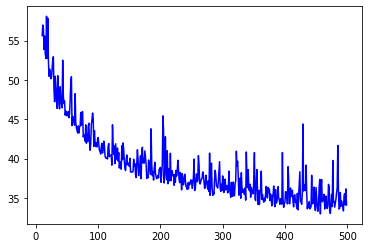

In [43]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

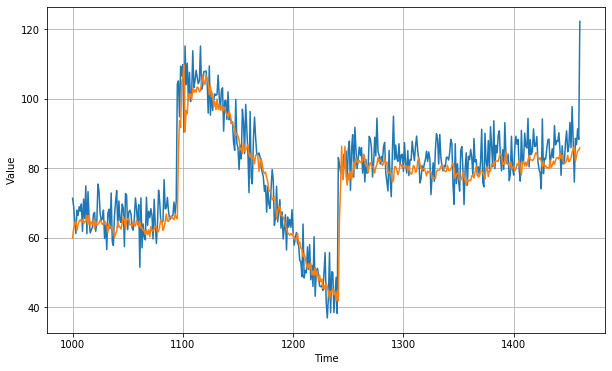

In [44]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0431447